# Dense Neural Network (NN) Exploration

In this notebook, we will lay out our approach for a Neural Network approach to predict a pose based on landmark. Additionally, we are storing out angle calculation and perspectively our angle error calculation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Neural Network

In [2]:
import tensorflow as tf


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras import models


In [4]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LeakyReLU
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import load_model
import joblib

In [5]:
from scipy.stats import uniform

In [6]:
# Load the datasets
train_df = pd.read_csv('train_landmark_xy_raw.csv')
val_df = pd.read_csv('val_landmark_xy_raw.csv')
test_df = pd.read_csv('test_landmark_xy_raw.csv')

In [7]:
X_train = train_df.iloc[:, 1:35]
y_train = train_df['y_sub']

In [8]:
X_val = val_df.iloc[:, 1:35]
y_val = val_df['y_sub']

In [9]:
X_test = test_df.iloc[:, 1:35]
y_test = test_df['y_sub']

In [10]:
# Convert labels to numerical values
label_mapping = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])
y_test_numeric = np.array([label_mapping[label] for label in y_test])

In [11]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Saving the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [12]:
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_numeric)
y_val_one_hot = to_categorical(y_val_numeric)
y_test_one_hot = to_categorical(y_test_numeric)

encoder = OneHotEncoder()

# Saving the encoder
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [13]:
# Build the neural network model
def initialize_model():
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(32, activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(label_mapping), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = initialize_model()


2023-11-24 14:52:04.967680: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-24 14:52:04.967698: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-24 14:52:04.967705: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-24 14:52:04.967731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-24 14:52:04.967744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=20)

# Start training
history = model.fit(X_train,
                    y_train_one_hot,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val_one_hot),
                    callbacks=[es])

# # Train the model with validation data
# history = model.fit(X_train,
#                     y_train_one_hot,
#                     epochs=10,
#                     batch_size=32,
#                     validation_data=(X_val, y_val_one_hot))


Epoch 1/100


2023-11-24 14:52:05.363422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-24 14:52:05.375359: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


17/17 [==============================] - 1s 28ms/step - loss: 2.1108 - accuracy: 0.2280 - val_loss: 1.4647 - val_accuracy: 0.4861
Epoch 2/100
17/17 [==============================] - 0s 12ms/step - loss: 1.4952 - accuracy: 0.4654 - val_loss: 1.1724 - val_accuracy: 0.6389
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 1.3187 - accuracy: 0.5383 - val_loss: 1.0274 - val_accuracy: 0.6389
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 1.2436 - accuracy: 0.5720 - val_loss: 0.9391 - val_accuracy: 0.6528
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 1.0983 - accuracy: 0.6056 - val_loss: 0.8707 - val_accuracy: 0.6875
Epoch 6/100
17/17 [==============================] - 0s 12ms/step - loss: 1.0819 - accuracy: 0.6206 - val_loss: 0.8112 - val_accuracy: 0.7361
Epoch 7/100
17/17 [==============================] - 0s 13ms/step - loss: 0.9234 - accuracy: 0.6692 - val_loss: 0.7443 - val_accuracy: 0.7778
Epoch 8/100
17/17 

In [15]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4480      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 13256 (51.78 KB)
Trainable params: 13256 (51.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


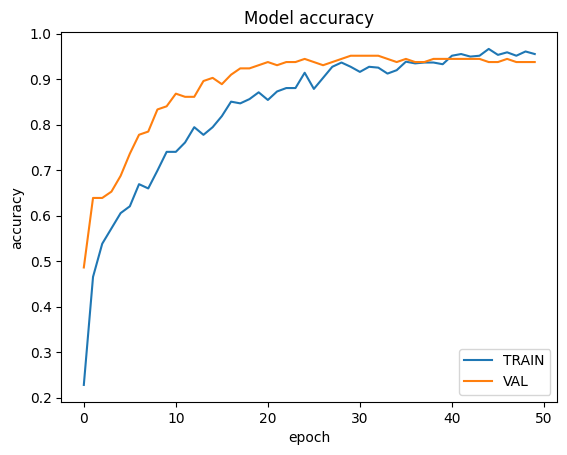

In [16]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()


In [17]:
# # Train the model with validation data
# history = model.fit(X_train,
#                     y_train_one_hot,
#                     epochs=10,
#                     batch_size=32,
#                     validation_data=(X_val, y_val_one_hot))

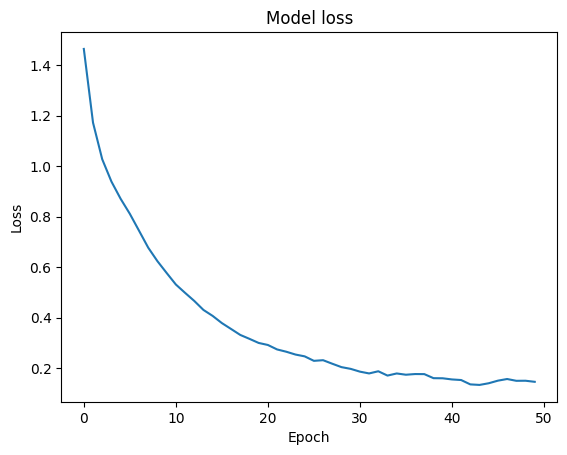

In [18]:
def plot_history(history):
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_history(history)


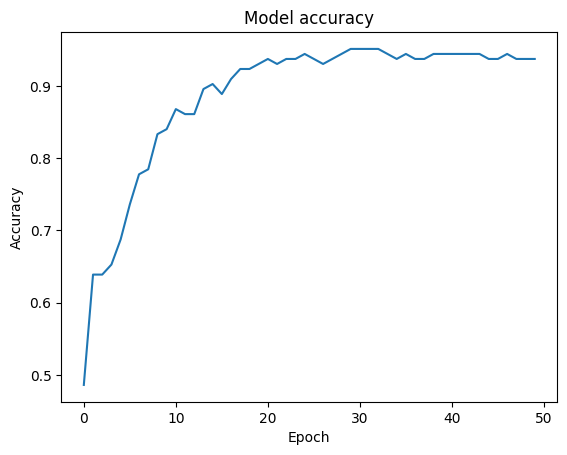

In [19]:
def plot_history_accuracy(history):
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

plot_history_accuracy(history)


In [20]:
# Convert test labels to one-hot encoding
y_test_one_hot = to_categorical(y_test_numeric)

# Evaluate the model on the test set
results = model.evaluate(X_test, y_test_one_hot, verbose=0)


In [21]:
print(f'Test Accuracy: {results[1]*100:.2f}%')
print(f'Test Loss: {results[0]}')


Test Accuracy: 95.45%
Test Loss: 0.21348987519741058


In [22]:
X_pred = X_test[-1].reshape(1,-1)

In [23]:
%time
prediction = model.predict(X_pred)


CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs
1/1 [==============================] - 0s 64ms/step


In [24]:
predict_class = np.argmax(prediction, axis = 1)
predict_class


array([7])

In [25]:
predicted_labels = np.argmax(prediction, axis=1)


In [26]:
predicted_class_names = [class_name for class_name, idx in label_mapping.items() if idx in predict_class]
predicted_class_names[0]


'warrior2_right'

In [27]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#   """Plots the confusion matrix."""
#   if normalize:
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print("Normalized confusion matrix")
#   else:
#     print('Confusion matrix, without normalization')

#   plt.imshow(cm, interpolation='nearest', cmap=cmap)
#   plt.title(title)
#   plt.colorbar()
#   tick_marks = np.arange(len(classes))
#   plt.xticks(tick_marks, classes, rotation=55)
#   plt.yticks(tick_marks, classes)
#   fmt = '.2f' if normalize else 'd'
#   thresh = cm.max() / 2.
#   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], fmt),
#               horizontalalignment="center",
#               color="white" if cm[i, j] > thresh else "black")

#   plt.ylabel('True label')
#   plt.xlabel('Predicted label')
#   plt.tight_layout()

# # Classify pose in the TEST dataset using the trained model
# y_pred = model.predict(X_test)

# # Convert the prediction result to class name
# y_pred_label = [predict_class[i] for i in np.argmax(y_pred, axis=1)]
# y_true_label = [predict_class[i] for i in np.argmax(y_test, axis=1)]

# # Plot the confusion matrix
# cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# plot_confusion_matrix(cm,
#                       class_names,
#                       title ='Confusion Matrix of Pose Classification Model')

# # Print the classification report
# print('\nClassification Report:\n', classification_report(y_true_label,
#                                                           y_pred_label))


In [28]:
model.save('24112023_sub_model.h5')  # Save the entire model

/Users/mirmachr/.pyenv/versions/3.10.6/envs/hathaproject/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
model.save('24112023_sub_model.keras')  # Save the entire model